In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

from lifelines.plotting import plot_lifetimes      # Lifeline package for the Survival Analysis
%pylab inline
figsize(12,6)

Populating the interactive namespace from numpy and matplotlib


In [2]:
##  create a dataframe
df = pd.read_csv("~/Documents/SEP-REAL/test datasets/cust_churn.csv")

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

from lifelines.plotting import plot_lifetimes      # Lifeline package for the Survival Analysis
%pylab inline
figsize(12,6)## Convert TotalCharges to numeric
df['TotalCharges']=pd.to_numeric(df['TotalCharges'],errors='coerce')

## Replace yes and No in the Churn column to 1 and 0. 1 for the event and 0 for the censured data.
df['Churn']=df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0 )

In [4]:
## Impute the null value with the median value

df.TotalCharges.fillna(value=df['TotalCharges'].median(),inplace=True)

In [5]:
## Create a list of Categorical Columns
cat_cols= [i  for i in df.columns if df[i].dtype==object]
cat_cols.remove('customerID')  ## customerID has been removed because it is unique for all the rows.

In [6]:
from lifelines import CoxPHFitter

In [7]:
## My objective here is to introduce you to the implementation of the model.Thus taking subset of the columns to train the model.
## Only using the subset of the columns present in the original data
df_r= df.loc[:,['tenure','Churn','gender','Partner','Dependents','PhoneService','MonthlyCharges','SeniorCitizen','StreamingTV']]
df_r.head() ## have a look at the data

,tenure,Churn,gender,Partner,Dependents,PhoneService,MonthlyCharges,SeniorCitizen,StreamingTV
0,1,0,Female,Yes,No,No,29.85,0,No
1,34,0,Male,No,No,Yes,56.95,0,No
2,2,1,Male,No,No,Yes,53.85,0,No
3,45,0,Male,No,No,No,42.30,0,No
4,2,1,Female,No,No,Yes,70.70,0,No


In [8]:
## Create dummy variables
df_dummy = pd.get_dummies(df_r, drop_first=True)
df_dummy.head()

,tenure,Churn,MonthlyCharges,SeniorCitizen,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,StreamingTV_No internet service,StreamingTV_Yes
0,1,0,29.85,0,0,1,0,0,0,0
1,34,0,56.95,0,1,0,0,1,0,0
2,2,1,53.85,0,1,0,0,1,0,0
3,45,0,42.30,0,1,0,0,0,0,0
4,2,1,70.70,0,0,0,0,1,0,0


In [9]:
# Using Cox Proportional Hazards model
cph = CoxPHFitter()   ## Instantiate the class to create a cph object
cph.fit(df_dummy, 'tenure', event_col='Churn')   ## Fit the data to train the model
cph.print_summary()    ## HAve a look at the significance of the features

<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
      baseline estimation = breslow
   number of observations = 7043
number of events observed = 1869
   partial log-likelihood = -15182.39
         time fit was run = 2021-03-07 07:08:16 UTC

---
                                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                               
MonthlyCharges                   -0.01       0.99       0.00            -0.01            -0.01                 0.99                 0.99
SeniorCitizen                     0.40       1.49       0.06             0.29             0.50                 1.33                 1.66
gender_Male                      -0.01       0.99       0.05            -0.10             0.08                 0.90                 1.08
Partner_Yes                      -0.81       0.45       0.05            -0.92            -0.70                 0.40                 0.50
Dependents_Yes                   -0.36       0.70       0.07            -0.49            -0.22                 0.61                 0.80
PhoneService_Yes                  0.69       2.00       0.10             0.49             0.90                 1.63                 2.45
StreamingTV_No internet service  -2.10       0.12       0.13            -2.36            -1.84                 0.09                 0.16
StreamingTV_Yes                  -0.19       0.83       0.06            -0.31            -0.07                 0.73                 0.93

                                     z      p   -log2(p)
covariate                                               
MonthlyCharges                   -6.13 <0.005      30.06
SeniorCitizen                     7.16 <0.005      40.15
gender_Male                      -0.23   0.82       0.29
Partner_Yes                     -14.93 <0.005     164.98
Dependents_Yes                   -5.21 <0.005      22.37
PhoneService_Yes                  6.65 <0.005      34.96
StreamingTV_No internet service -15.79 <0.005     184.09
StreamingTV_Yes                  -3.10 <0.005       9.03
---
Concordance = 0.71
Partial AIC = 30380.78
log-likelihood ratio test = 941.30 on 8 df
-log2(p) of ll-ratio test = 654.95

<AxesSubplot:xlabel='log(HR) (95% CI)'>

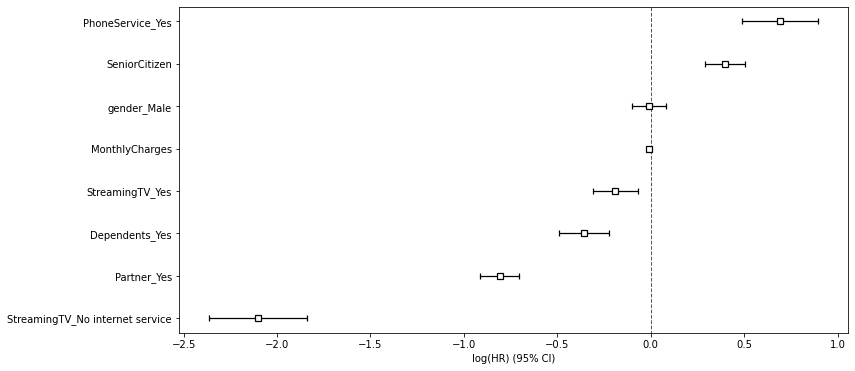

In [10]:
cph.plot()

In [11]:
## We want to see the Survival curve at the customer level. Therefore, we have selected 6 customers (rows 5 till 9).

tr_rows = df_dummy.iloc[5:10, 2:]
tr_rows

,MonthlyCharges,SeniorCitizen,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,StreamingTV_No internet service,StreamingTV_Yes
5,99.65,0,0,0,0,1,0,1
6,89.10,0,1,0,1,1,0,1
7,29.75,0,0,0,0,0,0,0
8,104.80,0,0,1,0,1,0,1
9,56.15,0,1,0,1,1,0,0


<AxesSubplot:>

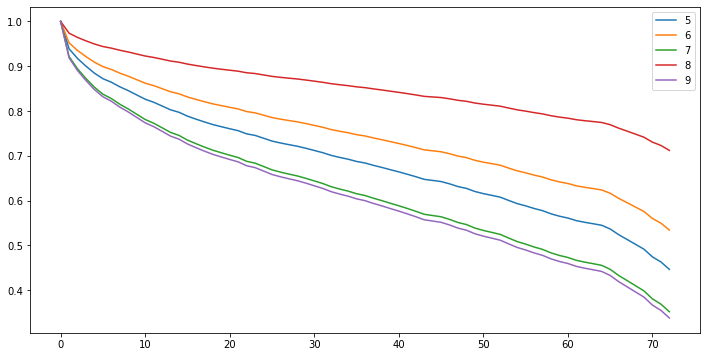

In [12]:
## Lets predict the survival curve for the selected customers. 
## Customers can be identified with the help of the number mentioned against each curve.
cph.predict_survival_function(tr_rows).plot()

# demo dataset

In [3]:
from datetime import datetime 
import matplotlib.pyplot as plt
from matplotlib import dates

In [3]:
bp_sep = pd.read_csv('test datasets/bloodpressure_sepsis_test.csv', parse_dates=['charttime'])

In [4]:
bp_sep['charttime'] = bp_sep['charttime'].apply(lambda x: x.to_pydatetime())

In [5]:
all_subjects = list(set(list(bp_sep['subject_id'])))

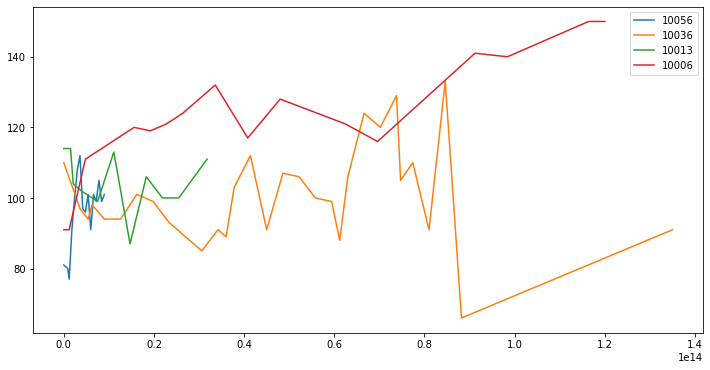

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)

for i in all_subjects:
    s_i = bp_sep.loc[(bp_sep['subject_id'] == i) & (bp_sep['itemid'] == 455)]
    
    s_i = s_i.dropna(how='any')
    
    base_dt = s_i.charttime.min()
    
    s_i['rel_time'] = s_i['charttime'].apply(lambda x: x - base_dt)
    
    plt.plot(s_i['rel_time'], s_i['value'], label=i)

plt.legend()
plt.show()

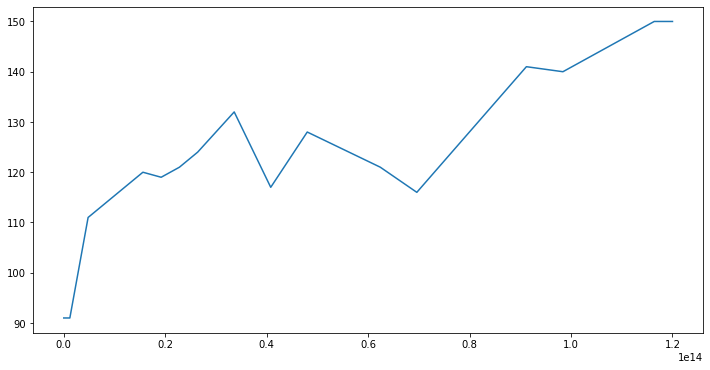

In [7]:
s_i = bp_sep.loc[(bp_sep['subject_id'] == 10006) & (bp_sep['itemid'] == 455)]
    
s_i = s_i.dropna(how='any')

minutes = dates.MinuteLocator()

base_dt = s_i.charttime.min()

s_i['rel_time'] = s_i['charttime'].apply(lambda x: x - base_dt)
fig = plt.figure()
ax = fig.add_subplot(111)
# ax.xaxis.set_major_locator(minutes)
plt.plot(s_i['rel_time'], s_i['value'])


In [8]:
s_i

,subject_id,charttime,itemid,value,rel_time
0,10006,2164-10-23 22:40:00,455,91.0,0 days 00:00:00
1,10006,2164-10-23 23:00:00,455,91.0,0 days 00:20:00
2,10006,2164-10-24 00:00:00,455,111.0,0 days 01:20:00
3,10006,2164-10-24 01:00:00,455,114.0,0 days 02:20:00
4,10006,2164-10-24 02:00:00,455,117.0,0 days 03:20:00
5,10006,2164-10-24 03:00:00,455,120.0,0 days 04:20:00
6,10006,2164-10-24 04:00:00,455,119.0,0 days 05:20:00
7,10006,2164-10-24 05:00:00,455,121.0,0 days 06:20:00
8,10006,2164-10-24 06:00:00,455,124.0,0 days 07:20:00
9,10006,2164-10-24 08:00:00,455,132.0,0 days 09:20:00


# MVP

In [58]:
sep_df_198 = pd.read_csv('mini_obv_198.csv', parse_dates=['charttime'])
sep_df_211 = pd.read_csv('mini_obv_211.csv', parse_dates=['charttime'])
sep_df_51 = pd.read_csv('mini_obv_51.csv', parse_dates=['charttime'])

frames = [sep_df_198, sep_df_211, sep_df_51]
sep_df = pd.concat(frames)

In [59]:
sep_df = sep_df[["subject_id", "charttime", "itemid", "value", "diagnosis"]]

In [60]:
sep_df["value"] = sep_df["value"].apply(pd.to_numeric, errors='coerce')

In [61]:
set(sep_df['itemid'])

{51, 198, 211}

In [62]:
sep_df['charttime'] = sep_df['charttime'].apply(lambda x: x.to_pydatetime())

In [63]:
all_subjects = list(set(list(sep_df['subject_id'])))

In [64]:
len(all_subjects)

2018

In [65]:
x = sep_df.groupby(['subject_id', 'itemid', 'diagnosis']).mean().reset_index()

In [66]:
x

,subject_id,itemid,diagnosis,value
0,21,51,CONGESTIVE HEART FAILURE,100.0
1,61,198,NON-HODGKINS LYMPHOMA;FEBRILE;NEUTROPENIA,15.0
2,94,51,PNEUMONIA,158.0
3,100,198,AORTIC INSUFFICIENCY\AORTIC VALVE REPLACEMENT;...,15.0
4,109,198,ABDOMINAL PAIN,15.0
...,...,...,...,...
2752,32791,211,TRAUMATIC HEAD INJURY/SDA,100.0
2753,32805,51,HYPOXIA,101.0
2754,32805,51,MYOCARDIAL INFARCTION,90.0
2755,32805,198,HYPOXIA,15.0


In [67]:
sep_df['itemid'] = sep_df['itemid'].apply(lambda x: str())

In [68]:
sep_df = pd.pivot_table(x, index=['subject_id', 'diagnosis'], columns=['itemid'], fill_value=np.nan).reset_index()

In [69]:
def calc_shock_index(row):
    if math.isnan(row['211']) or math.isnan(row['51']) or row['51'] == 0:
        return np.nan
    else:
        return row['211']/row['51']
    
def sepsis_binary_feature(row):
    diagnosis = row['diagnosis']
    
    if 'SEPSIS' in diagnosis:
        return 1
    else:
        return 0

In [71]:
sep_df.head(n=50)

subject_id                                          diagnosis  value  \
itemid                                                                   51   
0              21                           CONGESTIVE HEART FAILURE  100.0   
1              61          NON-HODGKINS LYMPHOMA;FEBRILE;NEUTROPENIA    NaN   
2              94                                          PNEUMONIA  158.0   
3             100  AORTIC INSUFFICIENCY\AORTIC VALVE REPLACEMENT;...    NaN   
4             109                                     ABDOMINAL PAIN    NaN   
5             109                               ACUTE  RENAL FAILURE    NaN   
6             109                              ALTERED MENTAL STATUS    NaN   
7             109                               CHEST PAIN;TELEMETRY    NaN   
8             109                                            DYSPNEA    NaN   
9             109                                       HYPERTENSION    NaN   
10            109                             HYPERTENSION EMERGENCY    NaN   
11            109                                HYPERTENSIVE CRISIS    NaN   
12            109                             HYPERTENSIVE EMERGENCY    NaN   
13            109                               HYPERTENSIVE URGENCY    NaN   
14            109                                           LEG PAIN    NaN   
15            109                       PULMONARY EDEMA;HYPERTENSION    NaN   
16            111                                          PNEUMONIA  129.0   
17            130           RULE-OUT MYOCARDIAL INFARCTION;TELEMETRY    NaN   
18            138      AORTIC STENOSIS\ AORTIC VALVE REPLACEMENT/SDA  109.0   
19            145                                THORACIC DISSECTION   93.0   
20            156  ABDOMINAL THORACIC ANEURYSM\ REPAIR ABDOMINAL ...    NaN   
21            191                                            ARF,GIB    NaN   
22            198                                       ANEURYSM/SDA    NaN   
23            198                            SUBARACHNOID HEMORRHAGE    NaN   
24            222                               LEFT LUNG NODULE/SDA    NaN   
25            222                                    RECTAL BLEEDING    NaN   
26            231                                          PNEUMONIA    NaN   
27            236                                   ? PNA INFILTRATE  152.0   
28            245                                      NON Q MI\CATH   91.0   
29            256                                     ABDOMINAL PAIN    NaN   
30            290                           ESOPHAGEAL DYSPLASIA/SDA  135.0   
31            303                     TYLENOL,OVERDOSE;LIVER FAILURE    NaN   
32            308            DILANTIN TOXICITY-MENTAL STATUS CHANGES  100.0   
33            313                                        C7 FRACTURE  175.0   
34            323                                           ACUTE MI    NaN   
35            339                             ACUTE PANCREATITIS/SDA  169.0   
36            352                                    LT LEG ISCHEMIA    NaN   
37            357                                          PNEUMONIA  137.0   
38            357                              ALTERED MENTAL STATUS    NaN   
39            357                             GASTROINTESTINAL BLEED   90.0   
40            357                                            SEIZURE  100.0   
41            357                                             SEPSIS   90.0   
42            362                                  SUBDURAL HEMATOMA    NaN   
43            364                                 MASSIVE HEMOPTYSIS    NaN   
44            405                                   C-SPINE FRACTURE  153.0   
45            408                        ENTERIC FISTULA;DEHYDRATION  146.0   
46            416                                                SAH    NaN   
47            426                            ACUTE CORONARY SYNDROME  100.0   
48            433                                     CAR

In [51]:
# sep_df.columns = ['subject_id', 'diagnosis', '51', '198', '211', '618', '676', '678', '8368', '220277']

sep_df.columns = ['subject_id', 'diagnosis', '198']
sep_df['shock_index'] = sep_df.apply (lambda row: calc_shock_index(row), axis=1)
sep_df['sepsis_binary'] = sep_df.apply (lambda row: sepsis_binary_feature(row), axis=1)

KeyError: '211'

In [74]:
train_sep_df = pd.DataFrame(columns=sep_df.columns)
for subject in all_subjects:
    s_i = sep_df.loc[sep_df['subject_id'] == subject]
    if len(s_i) > 1:
        y = s_i[s_i['diagnosis'].str.contains("SEPSIS")]
        if len(y) == 0:
            train_sep_df = train_sep_df.append(s_i.sample(n=1))
        else:
            train_sep_df = train_sep_df.append(y.sample(n=1))
    else:
        train_sep_df = train_sep_df.append(s_i)
        
train_sep_df = train_sep_df.dropna(subset=['455'])
train_sep_df

,subject_id,diagnosis,211,455,618,676,781,791,828,861,shock_index,sepsis_binary
43,10112,VF ARREST,93.867769,147.803419,20.462810,NaN,22.800000,0.680000,194.800000,15.460000,0.635085,0
44,10114,"PULMONARY EDEMA, MI",68.541176,117.102273,17.882353,37.742105,20.375000,1.175000,248.714286,9.057143,0.585310,0
45,10117,FEVER,103.612903,123.866667,25.247312,NaN,30.800000,3.420000,55.875000,5.800000,0.836487,0
46,10119,ACUTE CHOLECYSTITIS,58.842308,138.272727,21.888889,37.981395,25.187500,1.143750,199.571429,11.657143,0.425553,0
49,10124,LEFT HIP FRACTURE,88.187708,104.815789,23.910321,NaN,49.781250,11.848571,296.153846,7.976923,0.841359,0
50,10126,LIVER FAILURE,98.888889,112.285068,21.334842,36.701524,80.504587,2.450459,70.648438,9.393578,0.880695,0
51,10127,S/P MOTOR VEHICLE ACCIDENT,65.295533,102.194969,12.469083,NaN,15.629630,0.474074,315.720000,14.596000,0.638931,0
53,10132,NON SMALL CELL CANCER;HYPOXIA,110.428571,127.769231,22.000000,NaN,12.000000,0.500000,211.000000,12.100000,0.864281,0
0,10006,SEPSIS,82.000000,122.388889,25.375000,NaN,11.000000,3.500000,106.000000,4.600000,0.669995,1
1,10011,HEPATITIS B,82.398649,110.829787,15.447458,NaN,3.368421,0.563158,146.555556,6.542105,0.743470,0


In [25]:
sep_df.columns = ['subject_id', 'diagnosis', '211', '455', '618', '676', '781', '791', '828', '861']

In [26]:
sep_df['shock_index'] = sep_df.apply (lambda row: calc_shock_index(row), axis=1)

In [27]:
sep_df['sepsis_binary'] = sep_df.apply (lambda row: sepsis_binary_feature(row), axis=1)

In [28]:
sep_df.columns

Index(['subject_id', 'diagnosis', '211', '455', '618', '676', '781', '791',
       '828', '861', 'shock_index', 'sepsis_binary'],
      dtype='object')

In [90]:
X_train, X_test, y_train, y_test = train_test_split(
    train_sep_df[['211', '455', '618', '781', '791',
       '828', '861', 'shock_index']], train_sep_df['sepsis_binary'], test_size=0.15, random_state=42, stratify=train_sep_df['sepsis_binary'])

y_train=y_train.astype('int')
y_test=y_test.astype('int')

In [91]:
clf = RandomForestClassifier(max_depth=None, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [92]:
y_pred = clf.predict(X_test)

In [93]:
accuracy_score(y_test, y_pred)

0.75

In [94]:
f1_score(y_test, y_pred)

0.0

In [95]:
roc_auc_score(y_test, y_pred)

0.4285714285714286

In [96]:
y_pred

array([0, 0, 0, 1, 0, 0, 0, 0])

In [97]:
y_test

13    0
15    0
25    0
17    0
8     0
40    0
0     1
53    0
Name: sepsis_binary, dtype: int64

In [1]:
from google.cloud import bigquery

ImportError: cannot import name 'bigquery' from 'google.cloud' (unknown location)

In [ ]:
# code to build df

import pandas as pd
import numpy as np
from datetime import datetime 
sep_real = pd.read_csv("mini_obv_data.csv")
sep_df = sep_df[["subject_id", "charttime", "itemid", "value", "diagnosis"]]
sep_real = sep_real[["subject_id", "charttime", "itemid", "value", "diagnosis"]]
sep_df["value"] = sep_df["value"].apply(pd.to_numeric, errors='coerce')
sep_real["value"] = sep_real["value"].apply(pd.to_numeric, errors='coerce')
all_subjects = list(set(list(sep_real['subject_id'])))
x = sep_df.groupby(['subject_id', 'itemid', 'diagnosis']).mean().reset_index()
x = sep_real.groupby(['subject_id', 'itemid', 'diagnosis']).mean().reset_index()
sep_df['itemid'] = sep_df['itemid'].apply(lambda x: str())
sep_real['itemid'] = sep_real['itemid'].apply(lambda x: str())
sep_df = pd.pivot_table(x, index=['subject_id', 'diagnosis'], columns=['itemid'], fill_value=np.nan).reset_index()
sep_df.columns = ['subject_id', 'diagnosis', '51', '198', '211', '618', '676', '678', '8368', '220277']

sep_df['shock_index'] = sep_df.apply (lambda row: calc_shock_index(row), axis=1)
sep_df['sepsis_binary'] = sep_df.apply (lambda row: sepsis_binary_feature(row), axis=1)


train_sep_df = pd.DataFrame(columns=sep_df.columns)
for subject in all_subjects:
    s_i = sep_df.loc[sep_df['subject_id'] == subject]
    if len(s_i) > 1:
        y = s_i[s_i['diagnosis'].str.contains("SEPSIS")]
        if len(y) == 0:
            train_sep_df = train_sep_df.append(s_i.sample(n=1))
        else:
            train_sep_df = train_sep_df.append(y.sample(n=1))
    else:
        train_sep_df = train_sep_df.append(s_i)

### setting up env on instance

sudo apt-get upgrade
sudo curl https://bootstrap.pypa.io/get-pip.py -o get-pip.py
sudo apt-get install python3-distutils
sudo apt-get install python3-apt
sudo python3 get-pip.py
sudo pip install --upgrade 'google-cloud-bigquery[bqstorage,pandas]'
export GOOGLE_APPLICATION_CREDENTIALS="eco-rune-309016-43e0775bb03c.json" 

In [ ]:
# code to download data

import google.auth
from google.cloud import bigquery
from google.cloud import bigquery_storage

# Explicitly create a credentials object. This allows you to use the same
# credentials for both the BigQuery and BigQuery Storage clients, avoiding
# unnecessary API calls to fetch duplicate authentication tokens.
credentials, your_project_id = google.auth.default(
    scopes=["https://www.googleapis.com/auth/cloud-platform"]
)

# Make clients.
bqclient = bigquery.Client(credentials=credentials, project=your_project_id,)
bqstorageclient = bigquery_storage.BigQueryReadClient(credentials=credentials)

query_string = """
select *
from `eco-rune-309016.mimic_iii_data.mini_obv_data`
"""

dataframe = (
    bqclient.query(query_string)
    .result()
    .to_dataframe(bqstorage_client=bqstorageclient)
)
print(dataframe.head())

In [5]:
pd.set_option('display.max_rows', 1000000000)

## test mini obv

In [1]:
import pandas as pd

In [8]:
sep_real = pd.read_csv('~/Downloads/mini_sep_df.csv')

In [10]:
sep_real.head(50)

,subject_id,diagnosis,51,198,211,618,676,678,8368,220277,shock_index,sepsis_binary
0,2,NEWBORN,NaN,NaN,140.750000,NaN,NaN,NaN,NaN,NaN,NaN,0
1,3,HYPOTENSION,117.792793,11.285714,92.376471,16.987879,36.951042,97.262501,60.648649,NaN,0.784229,0
2,4,"FEVER,DEHYDRATION,FAILURE TO THRIVE",NaN,15.000000,90.354839,25.333333,NaN,98.066667,NaN,NaN,NaN,0
3,5,NEWBORN,NaN,NaN,140.000000,NaN,NaN,NaN,NaN,NaN,NaN,0
4,6,CHRONIC RENAL FAILURE/SDA,153.605263,14.925926,86.549451,14.131868,NaN,97.800000,59.815789,NaN,0.563454,0
5,7,NEWBORN,NaN,NaN,132.000000,NaN,NaN,NaN,NaN,NaN,NaN,0
6,8,NEWBORN,NaN,NaN,137.928571,NaN,NaN,NaN,NaN,NaN,NaN,0
7,9,HEMORRHAGIC CVA,149.716495,3.907895,85.994819,16.316062,NaN,97.637838,76.731959,NaN,0.574384,0
8,10,NEWBORN,NaN,NaN,152.246231,NaN,NaN,NaN,NaN,NaN,NaN,0
9,11,BRAIN MASS,NaN,14.823529,84.948718,18.138889,NaN,98.277779,NaN,NaN,NaN,0


In [7]:
sep_real.shape

(10000, 7)

SELECT c.subject_id, c.charttime, d.LABEL, c.itemid, d.UNITNAME, c.value, a.diagnosis, p.dob, a.admittime
from `physionet-data.mimiciii_clinical.admissions` as a
join `physionet-data.mimiciii_clinical.chartevents` as c on a.subject_id=c.subject_id
join `physionet-data.mimiciii_clinical.d_items` as d on c.ITEMID=d.ITEMID
join `physionet-data.mimiciii_clinical.patients` as p on a.subject_id=p.subject_id

join (
    select subject_id, sum(num_hours) as total_hours
    from
        (select subject_id, admittime, dischtime, TIMESTAMP_DIFF(DISCHTIME, ADMITTIME, HOUR) AS num_hours
        from `physionet-data.mimiciii_clinical.admissions`)
    group by subject_id
    having sum(num_hours) > 7
    and sum(num_hours) < 2000
) x on a.subject_id=x.subject_id

-- where a.diagnosis like '%SEPSIS%'
where c.itemid in (220277, 618, 211, 51, 8368, 198, 676, 678)
and TIMESTAMP_DIFF(a.ADMITTIME, p.DOB, DAY) > 18*365
and TIMESTAMP_DIFF(a.ADMITTIME, p.DOB, DAY) < 120*365
--and total_hours > 7
--and total_hours < 2000;